# Spatial Model


Authoritarians and non-authoritarians thus differ in their perceived ideological proximity to the two parties. By extension, we might observe that ideological proximity has a different effect on voting for authoritarians. The basic argument is that if a particular candidate or party advances policy that maximizes a voter’s utility through policy, the voter should prefer and subsequently vote for that candidate or party (relative to the alternative; Jessee  2012).

It seems that ideological proximity can be defined in different ways -- it confuses me -- but this what I did in the analysis I circulated. Here's the model

``` 
# differenceR <- ideology - data$ideologyCR
# differenceD <- ideology - data$ideologyCD

spatial_dat <- filteredData %>%
  select(vote, differenceD, differenceR, authoritarianism, authoritarianism2, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  mutate(diffCR = differenceR * differenceR) %>%
  mutate(diffCD = differenceD * differenceD) %>%
  mutate(diffOfdiff = diffCD - diffCR)


spatialModel <- brm(vote ~ authoritarianism + authoritarianism2 + diffOfdiff +
           authoritarianism * diffOfdiff + authoritarianism2 * diffOfdiff +
           female + age + college + income + jewish + catholic + other +
           (1 + authoritarianism + authoritarianism2 + diffOfdiff +
            authoritarianism * diffOfdiff + authoritarianism2 * diffOfdiff | year),
      family = bernoulli(link = "probit"),
      data = spatial_dat,
      chains = 3,
      cores = 8,
      seed = 1234,
      iter = 2000,
      control = list(adapt_delta = 0.9)
)
```

It's just a probit. *diffOdfdif* is the differences in ideological distances (squared) to the party candidate

$$
\mathrm{diffOfdiff} = (x_i - X_{Democrat})^2 - (x_i - X_{Republican})^2
$$

I interacted the variable with authoritarianism and authoritarianism-squared. And these effects vary across ANES cross section. So a score of zero would mean that the person is equidistant to both parties, and should be indifferent. A positive score means indicates the person is closer to the Republican candidate. A negative score means the person is closer to the Democratic candidate.

Here is what I wrote up before...shortened a bit.

 If one votes for the most proximal candidate -- then one that yields the most utility (U) -- then it follows that a voter will cast a Republican vote if the utility gained from the Republican candidate is higher than what would be obtained from the Democratic candidate. It's common to define utility in terms of ideological proximity -- which candidate most represents one's policy views and are thus likely to maximize one's utility. We might anticipate that utility is higher when the candidate's ideology is close. We calculate the squared ideological proximity to both candidates, $-(x_i - X_R)^2$ and $-(x_i - X_D)^2$, where $x_i$ corresponds to the respondent's ideology, and $X_D$ and $X_R$ represent the perceived ideology of the Democratic and Republican presidential candidates, respectively. Sometimes these values are just fixed at the sample means, but as we've already shown, perceptions of parties varies quite a bit. 
 
 So if this is the utility model

\begin{align*}
\mathrm{Vote \; Republican} =& pr(U(R_i) > U(D_i))\\
 \end{align*}

As Jessee notes, we could write this generally as $U_i(k) = -(x_i - X_k)^2$, where $k$ is the party candidate. Under the spatial model, the voter should select a candidate that minimizes the distance between the voter's ideal point and the candidate's ideal point. So, the comparison of the Republican to the Democrat would be: 

\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[(U(R_i) > U(D_i)]=\\
 =& pr(-(x_i - X_R)^2  > -(x_i - X_D)^2) \\
 \end{align*}

The person votes Republican when the utility of voting Republican is greater than the utility of voting Democratic -- i.e., the voter is ideologically closer to the Republican candidate. The stochastic version of this just means that the utility of voting Republican is greater than the utility of voting Democratic plus some error term.


\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[(U(R_i) > U(D_i)]=\\
 =& pr[(-(x_i - X_R)^2 + e_{i,R})  > (-(x_i - X_D)^2 +  e_{i,D})] \\
 \end{align*}

Including two additional parameters in this model allows us to ascertain whether voters follow the tenets of the spatial model.

\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[(U(R_i) > U(D_i)]=\\
 =& pr[(-a(x_i - X_R)^2 + b_{Republican} + e_{i,R})  > (-a(x_i - X_D)^2 +  b_{Democrat} + e_{i,D})] \\
 =& pr[(-a(x_i - X_R)^2  + a(x_i - X_D)^2  +  b_{Republican} -  b_{Democrat}   >  e_{i,D} - e_{i,R}))] \\
  =& \Phi(\beta_1*[(x_i - X_R)^2  + (x_i - X_D)^2]  + \beta_0 ))\\
 \end{align*}

 This can be written and estimated using a probit regression model. The intercept corresponds to the bias parameter -- it should be zero because when the difference variable is 0 that means the person reports being equidistant from both parties. On the other hand, the slope corresponds to precision. It's a weight corresponding to how aligned proximity is with voting. Here $\beta_0$ and $\beta_2$ approximate bias and precision respectively. 

If there is no bias -- voters do not lean towards one party when they're ideologically closer to the other -- then $\beta_0$ should be zero. If ideological proximity is only loosely related to voting -- perhaps some ideological distance does not strongly move a voter from one candidate to another, then $\beta_1$ should be small. If proximity unrelated to voting, the estimate should be zero. If proximity is strongly related to voting, then the estimate should be larger.


Loading required package: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidybayes'


The following objects are masked from 'package:brms':

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


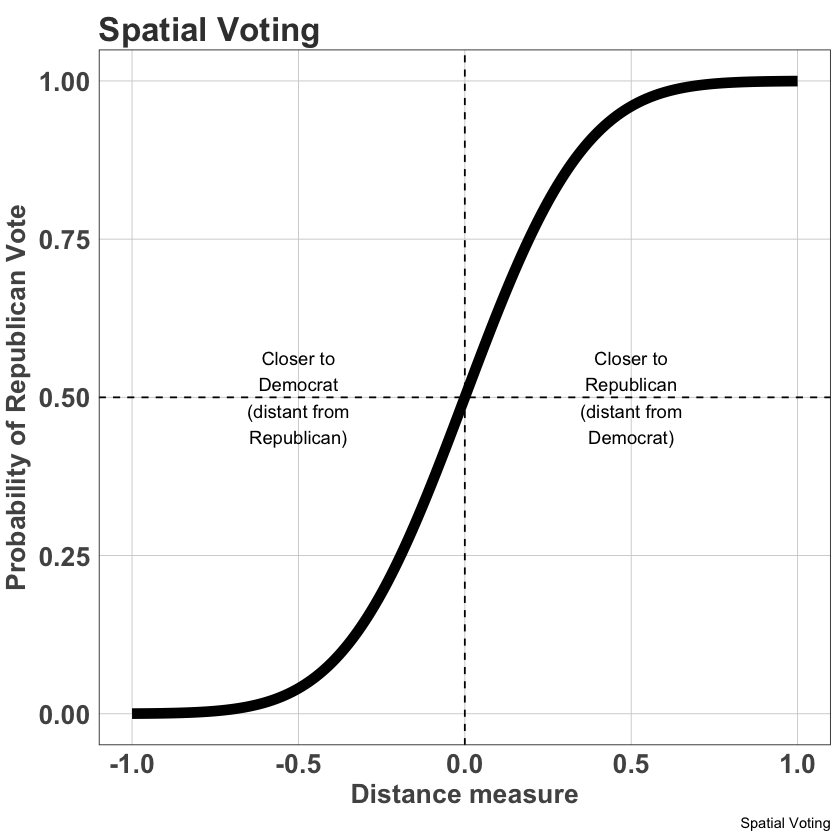

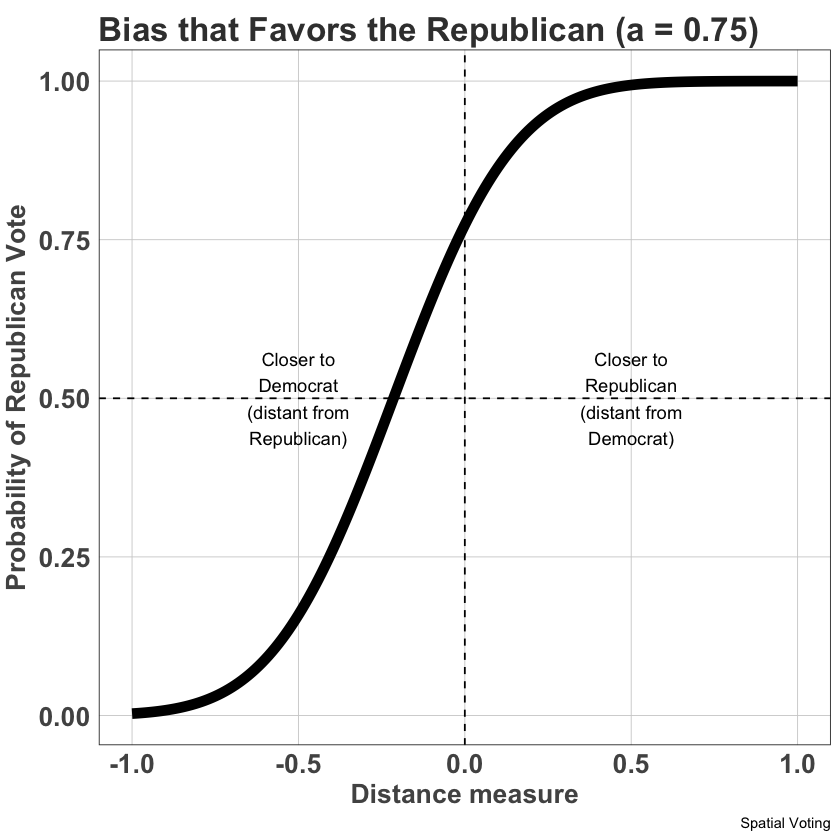

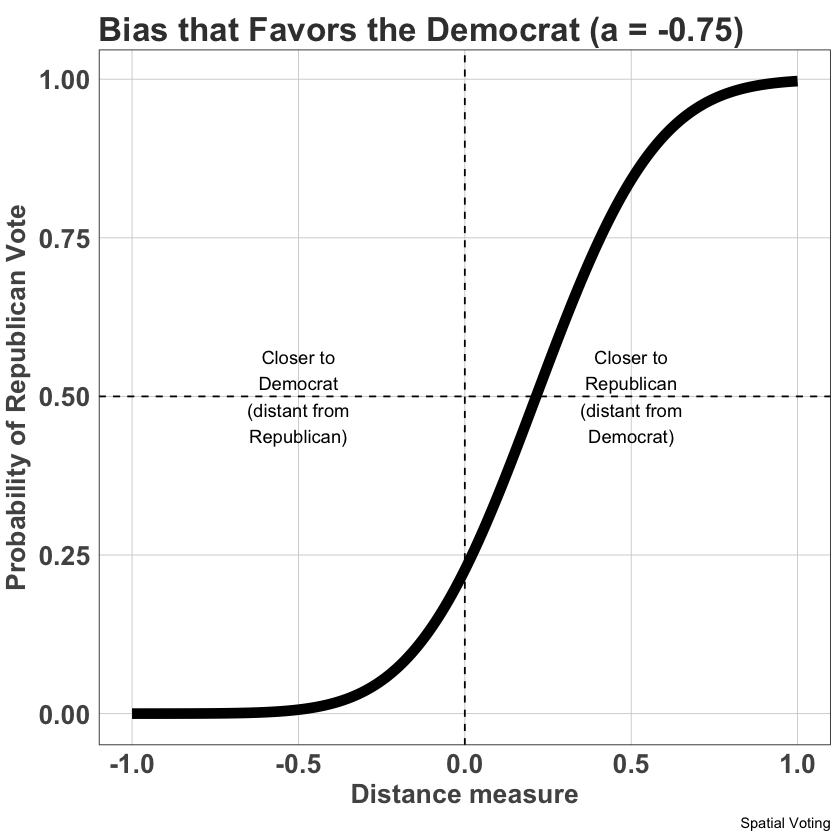

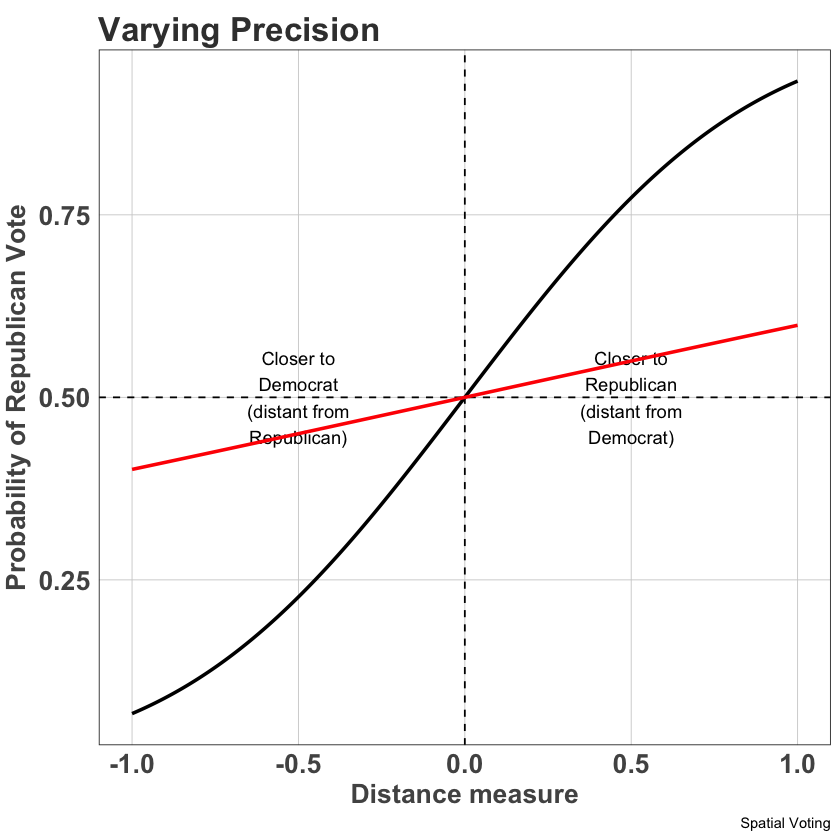

In [3]:
rm(list = ls())
library(brms)
library(modelr)
library(dplyr)
library(modelr)
library(tidybayes)
library(haven)
library(ggplot2)
library(dplyr)
library(cowplot)
library(metR)

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)
a = 0
b = 3.5
x = seq(-1, 1, 0.01)
y = pnorm(a + b * x)

ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +

  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Spatial Voting") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
    geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed")

#####
a <- 0.75
b <- 3.5
x <- seq(-1, 1, 0.01)
y <- pnorm(a + b * x)
###33
ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Bias that Favors the Republican (a = 0.75)") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") +
  geom_ribbon(aes(x = 0, ymin = 0.5, ymax = y), fill = "red", alpha = 0.2)

#####
a <- -0.75
b <- 3.5
x <- seq(-1, 1, 0.01)
y <- pnorm(a + b * x)
#####

ggplot(data = data.frame(x = x, y = y), aes(x = x, y = y)) +
  geom_line(size = 3) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Bias that Favors the Democrat (a = -0.75)") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed")
   #Shade under the curve and greater than 0.5 and less than x less than 0


a <- 0
b1 <- 1.5
b2 <- 0.25
x <- seq(-1, 1, 0.01)
y1 <- pnorm(a + b1 * x)
y2 <- pnorm(a + b2 * x)

ggplot(data = data.frame(x = x, y = y1, y2 = y2), aes(x = x, y = y)) +
  geom_line(size = 1) +
  ylab("") +
  geom_vline(xintercept = 0, linetype = "dashed") +
  annotate("text", x = -0.5, y = 0.5, label = "Closer to\nDemocrat\n(distant from\nRepublican)", colour = "black") +
  annotate("text", x = 0.5, y = 0.5, label = "Closer to\nRepublican\n(distant from\nDemocrat)", colour = "black") +
  scale_y_continuous("Probability of Republican Vote") +
  scale_x_continuous("Distance measure") +
  ggtitle("Varying Precision") +
  theme_bw() +
  theme(
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  ) +
  ggtheme +
  labs(caption = "Spatial Voting") +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") +
  geom_line(aes(x = x, y = y2), size = 1, colour = "red")


The following model is then estimated




\begin{align*}
pr(\mathrm{Vote \; Republican}) =& pr[U(R_i) > U(D_i)]=\\
  =& \Phi(a + b_{0,k} + b_{1,k} x_{Prox: i, k} +  b_{2, k}x_{auth: i, k} +  b_{2, k}x_{auth^2: i, k} +  b_{3, k}x_{Prox: i, k}x_{auth: i, k}+  b_{4, k}x_{Prox: i, k}x_{auth^2: i, k})\\
b_{j,k} \sim \mathcal{N}(0, \sigma^2_{j,k})
 \end{align*}

In this model, $x_{Prox} = (x_i - X_D)^2 - (x_i - X_R)^2$ corresponds to the differences in proximity scores. $x_{auth}$ and $x_{auth^2}$ correspond to the authoritarianism and authoritarianism-squared variables. We also specify the interaction between proximity and authoritarianism and proximity and authoritarianism^2. The model is estimated using the brms package in R (Bürkner 2017). The model is estimated using 3 chains, 2000 iterations, and a 0.9 adaptation delta. 

Because we are interested in comparing authoritarians to non-authoritarians, we use this model to simulate the predicted probability of voting Republican for both groups. We simulate the predicted probability of voting Republican for both groups at the 5th, 25th, 50th, 75th, and 95th percentiles of the proximity variable. We then plot the predicted probabilities for both groups.



`summarise()` has grouped output by 'diffOfdiff', 'year'. You can override
using the `.groups` argument.


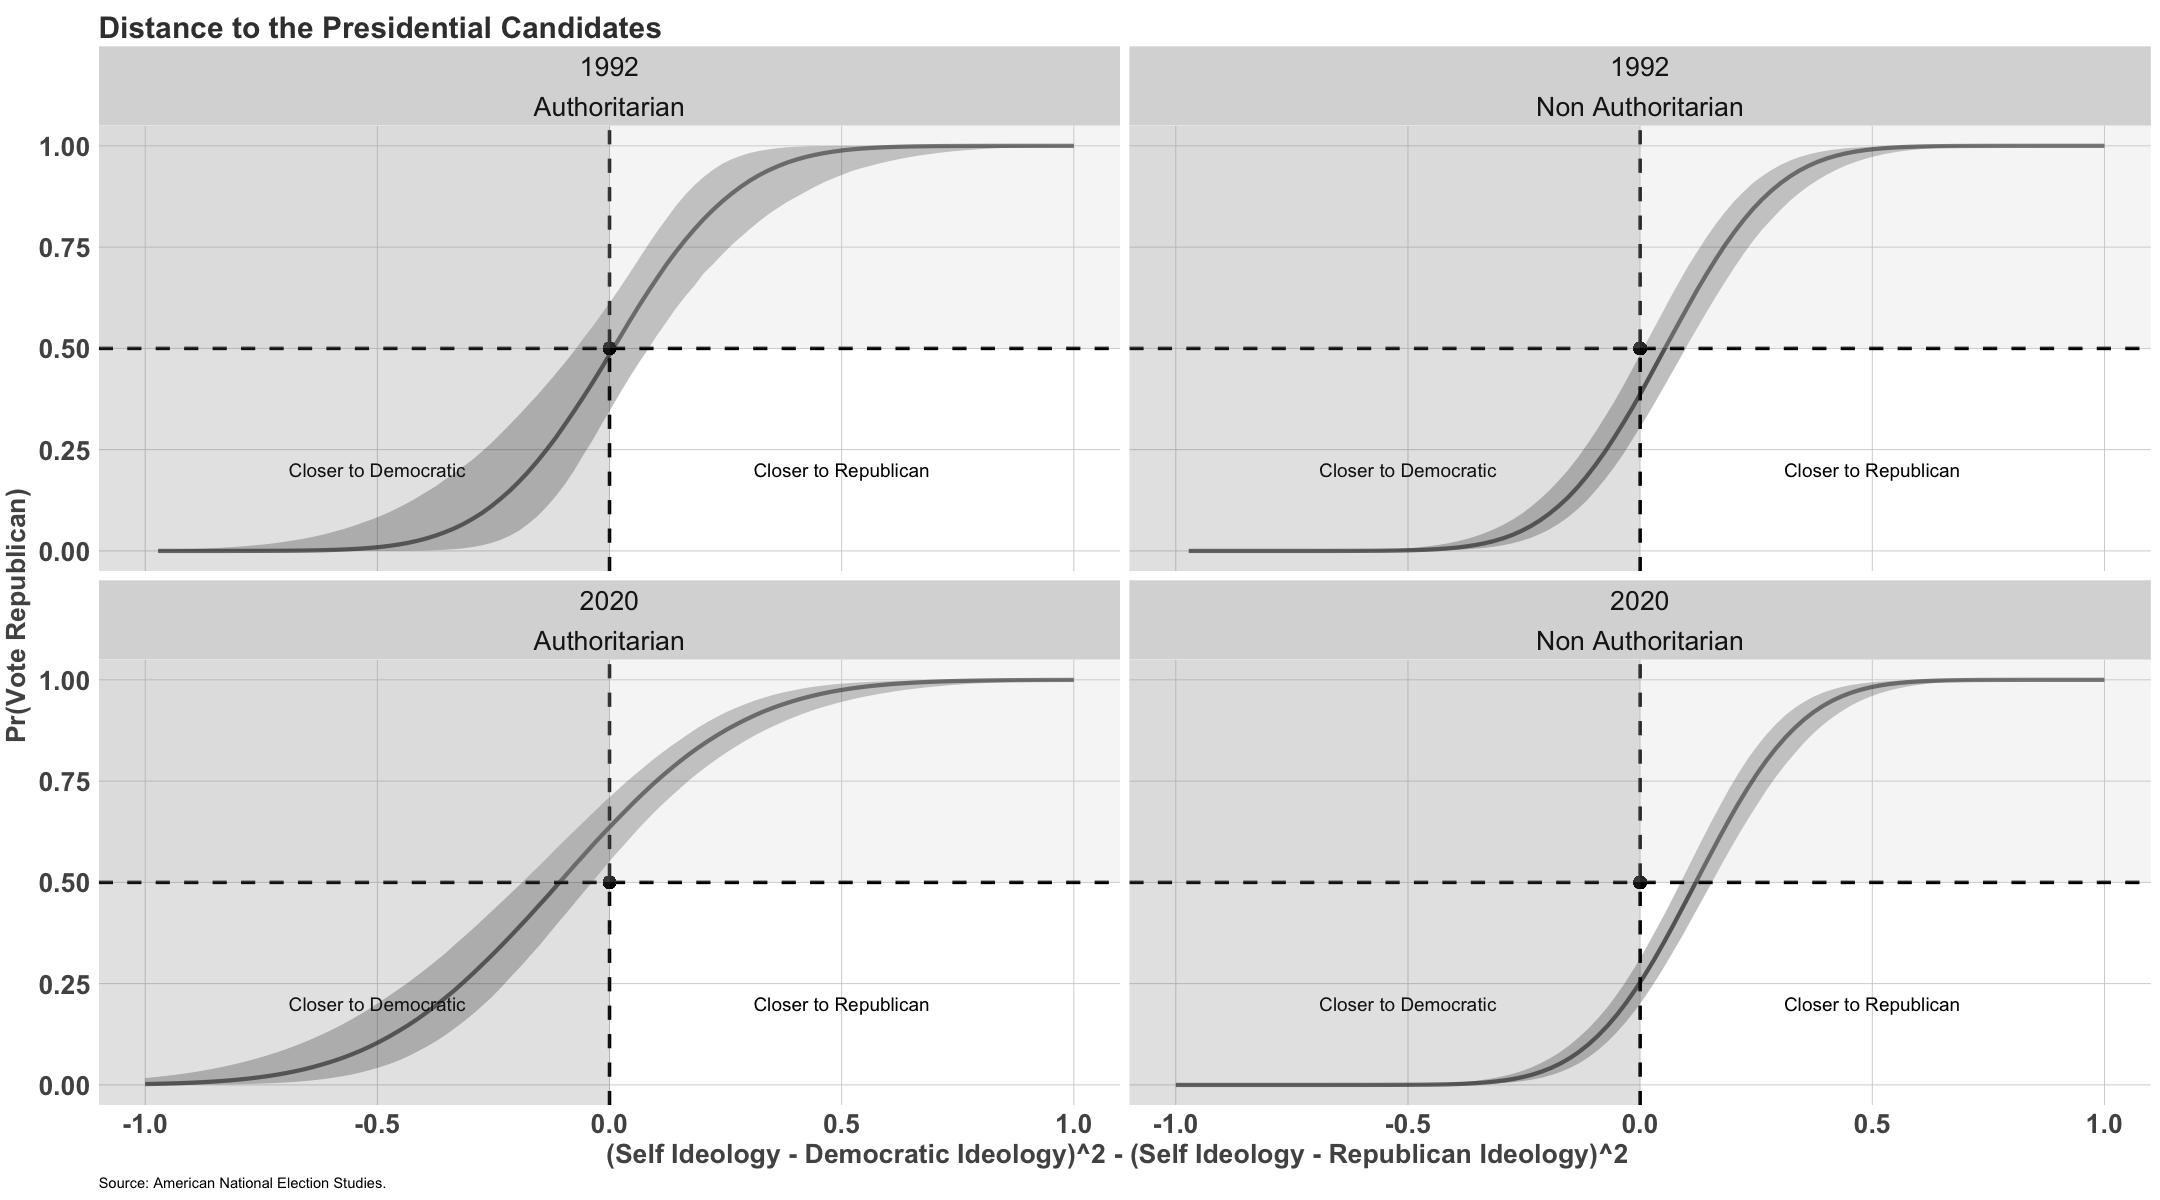

In [96]:
options(repr.plot.width = 18, repr.plot.height = 10)

library(dplyr)
library(brms)
library(modelr)
library(dplyr)
library(modelr)
library(tidybayes)
library(haven)
library(ggplot2)
library(dplyr)
library(cowplot)
library(metR)

load("/Users/Chris/AuthoritarianismBookProject_FedericoFeldmanWeber/Chapter Analysis/Chapter 9 Analysis/ch9models.rda")

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)

ch9models[["spatialDat"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = seq_range(diffOfdiff, 100),
    authoritarianism = seq_range(authoritarianism, n = 2)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch9models[["spatialModel"]]) %>%
  mutate(probability = .epred) %>%
  group_by(diffOfdiff, year, authoritarianism) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),
    min = quantile(probability, prob = 0.025),
    max = quantile(probability, prob = 0.975)
  ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  filter(year == 1992 | year ==2020) %>%
  ggplot(aes(ymin = min, ymax = max, x = diffOfdiff, y = mean)) +
  facet_wrap(~ year + Authoritarianism, ncol = 2) +
  geom_line(size = 1.2, alpha = 0.60) +
  geom_ribbon(alpha = 0.3) +
  ggtitle("Distance to the Presidential Candidates") +
  ylab("Pr(Vote Republican)") +
  xlab("Year") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  # scale_y_continuous(limits = c(.3, 0.8)) +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 18, lineheight = 0.9)) +
  # plot a horizontal line at 0.5
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1) +
  # plot a vertical line at 0
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", size = 1) +
  # add a dot where the line crosses the y intercept
  geom_point(aes(x = 0, y = 0.5), size = 3, color = "black") +
  xlab("(Self Ideology - Democratic Ideology)^2 - (Self Ideology - Republican Ideology)^2  ") +
  # shade everything to the left of the vertical line, light gray
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "black") +
  # label the shaded area "Closer to Democratic Candidate"
  annotate("text", x = -0.5, y = 0.2, label = "Closer to Democratic", size = 4, color = "black") +
  # shade everything to the left of the vertical line, light gray
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "grey") +
  # label the shaded area "Closer to Democratic Candidate"
  annotate("text", x = 0.5, y = 0.2, label = "Closer to Republican", size = 4, color = "black") +
  # color everything above 0.5 as light red
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = Inf, alpha = 0.2, fill = "lightgrey")


In [98]:
ch9models[["spatialDat"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = 0,
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch9models[["spatialModel"]]) %>%
  mutate(probability = .epred) %>%
  group_by(diffOfdiff, year, authoritarianism) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),
    min = quantile(probability, prob = 0.025),
    max = quantile(probability, prob = 0.975)
  )

`summarise()` has grouped output by 'diffOfdiff', 'year'. You can override
using the `.groups` argument.


diffOfdiff,year,authoritarianism,mean,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1992,0,0.3871228,0.3047961,0.4850946
0,1992,1,0.4844736,0.3456114,0.6118221
0,2000,0,0.3337805,0.2282913,0.4571570
0,2000,1,0.5942327,0.3765333,0.7789785
0,2004,0,0.4552562,0.3402495,0.5752877
0,2004,1,0.6471276,0.4946010,0.7718948
0,2008,0,0.3281615,0.2478906,0.4190526
0,2008,1,0.5846523,0.4598904,0.6998466
0,2012,0,0.3176245,0.2285070,0.4141371


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


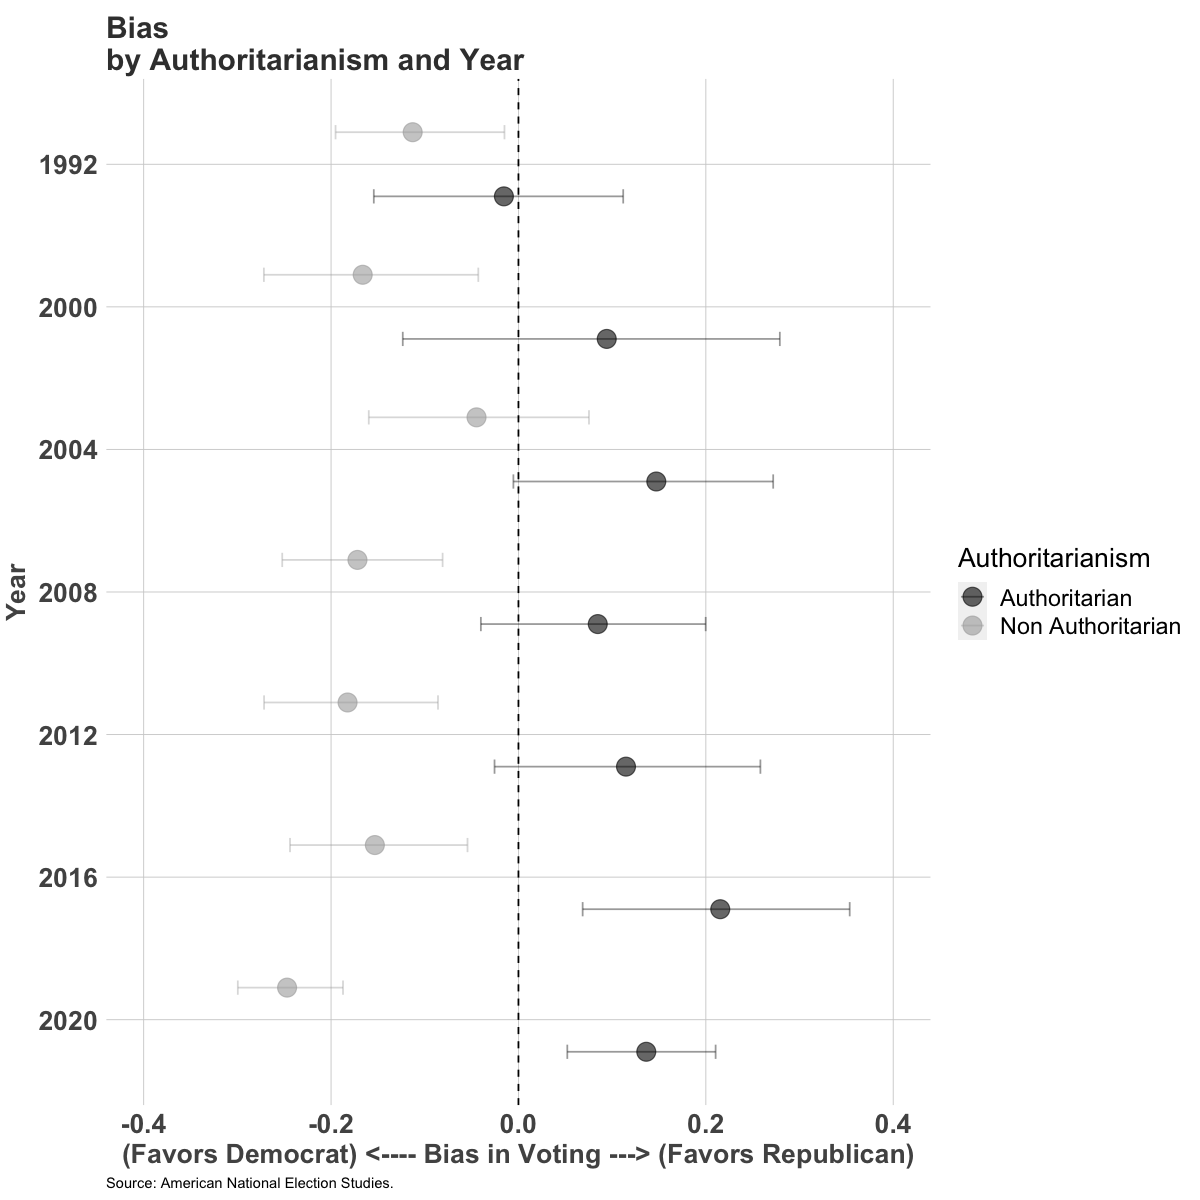

In [100]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Extract the intercepts from the model
ch9models[["spatialDat"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = 0,
    authoritarianism = seq_range(authoritarianism, n = 2) ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch9models[["spatialModel"]]) %>%
  mutate(probability = .epred) %>%
  group_by(year, authoritarianism) %>%
  summarize(
    mean = quantile(probability - 0.5, prob = 0.5),
    min = quantile(probability - 0.5, prob = 0.025),
    max = quantile(probability - 0.5, prob = 0.975)
  ) %>%
    mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
    mutate(year = factor(year, levels = rev(c("1992", "2000", "2004", "2008", "2012", "2016", "2020")))) %>%

ggplot(aes(x = as.factor(year), y = mean, ymin = min, ymax = max, color = as.factor(Authoritarianism), group = as.factor(Authoritarianism) )) +
  geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
  ggtitle("Bias\nby Authoritarianism and Year") +
  # Add a subtitle
  ylab("Polarization") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  scale_y_continuous("(Favors Democrat) <---- Bias in Voting ---> (Favors Republican)", limits = c(-0.4, 0.4)) +
  labs(x = "Year") +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  #Chagne teh plot title size
  theme(plot.title = element_text(size = 18)) +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  #reverse the x axis
  coord_flip() +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  # revser the order of year
  #Change the color of label
  scale_color_manual("Authoritarianism", values = c("black", "darkgrey"))   #


In [112]:
# Extract the intercepts from the model
ch9models[["spatialDat"]] %>%
  group_by(year) %>%
  data_grid(
    diffOfdiff = -0.059850382	,
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch9models[["spatialModel"]]) %>%
  mutate(probability = .epred) %>%
  group_by(year, authoritarianism) %>%
  summarize(
    mean = quantile(probability , prob = 0.5),
    min = quantile(probability - 0.5, prob = 0.025),
    max = quantile(probability - 0.5, prob = 0.975)
  ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  mutate(year = factor(year, levels = rev(c("1992", "2000", "2004", "2008", "2012", "2016", "2020"))))

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,authoritarianism,mean,min,max,Authoritarianism
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1992,0,0.2724538,-0.29935059,-0.13964582,Non Authoritarian
1992,1,0.3734862,-0.26999955,0.01895483,Authoritarian
2000,0,0.2249068,-0.36200537,-0.16589731,Non Authoritarian
2000,1,0.5052193,-0.21801802,0.22486804,Authoritarian
2004,0,0.3344093,-0.26851611,-0.04871751,Non Authoritarian
2004,1,0.5660369,-0.10442465,0.21351542,Authoritarian
2008,0,0.2245829,-0.34274797,-0.19196815,Non Authoritarian
2008,1,0.5039486,-0.12877356,0.13494050,Authoritarian
2012,0,0.2135886,-0.35973710,-0.20001760,Non Authoritarian


In [86]:
ch9models[["spatialModel"]]
library(shinystan)
launch_shinystan(ch9models[["spatialModel"]])

Warning message:
"There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


 Family: bernoulli 
  Links: mu = probit 
Formula: vote ~ authoritarianism + authoritarianism2 + diffOfdiff + authoritarianism * diffOfdiff + authoritarianism2 * diffOfdiff + ((1 + diffOfdiff + authoritarianism + authoritarianism2 + diffOfdiff * authoritarianism + authoritarianism2 * diffOfdiff) | year) 
   Data: spatial_dat (Number of observations: 4887) 
  Draws: 3 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 3000

Group-Level Effects: 
~year (Number of levels: 7) 
                                                              Estimate
sd(Intercept)                                                     0.26
sd(diffOfdiff)                                                    0.38
sd(authoritarianism)                                              0.38
sd(authoritarianism2)                                             0.30
sd(diffOfdiff:authoritarianism)                                   0.76
sd(diffOfdiff:authoritarianism2)                        


Launching ShinyStan interface... for large models this  may take some time.


Listening on http://127.0.0.1:4248



## Varying Slopes

Here, I extract the slopes from the model

\begin{align*}
 b_{low}=& b_{1,k} x_{Prox: i, k} 
 \end{align*}

\begin{align*}
 b_{high}=  b_{1,k} x_{Prox: i, k} +   b_{3, k}x_{Prox: i, k} +  b_{4, k}x_{Prox: i, k}\\
 \end{align*}



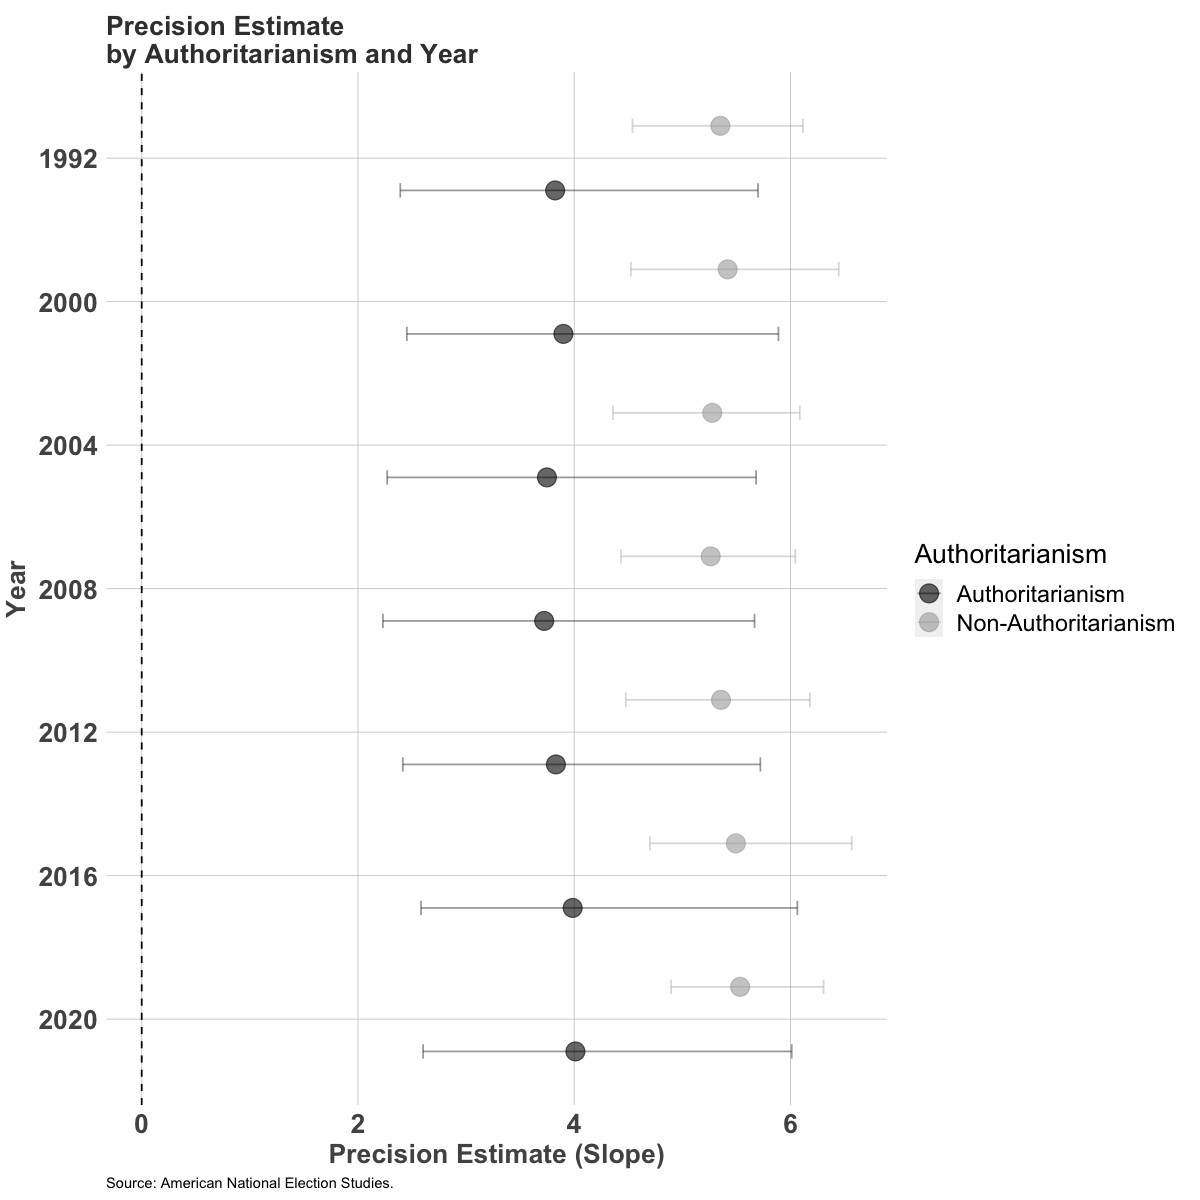

In [105]:
# The value of x when pr =0.5
# Just plug in different values, 0, 1 of authoritarianism to calculate the slope. It's just the fixed and random effects.
pred <-ch9models[["spatialModel"]] %>%
  spread_draws(b_diffOfdiff, `b_authoritarianism:diffOfdiff`, `b_authoritarianism2:diffOfdiff`, r_year[year, term]) %>%
  filter(term == "diffOfdiff" | term == "authoritarianism:diffOfdiff" | term == "authoritarianism2:diffOfdiff")   %>%
  group_by(.chain, .iteration, .draw, year) %>%
  mutate(re_sum = sum(r_year)) %>%
  filter(term == "diffOfdiff") %>%
  group_by(year) %>%
  summarize(
    a_median = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.5),
    a_high = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.975),
    a_low = quantile(`b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum, 0.025),
    na_high = quantile(`b_diffOfdiff` + r_year[term == "diffOfdiff"], 0.975),
    na_low = quantile(`b_diffOfdiff` + r_year[term == "diffOfdiff"], 0.025),
    na_median = median(`b_diffOfdiff` + r_year[term == "diffOfdiff"])
  )

rbind(
pred %>% select(mean = a_median, high = a_high, low = a_low, year) %>% mutate(group = "Authoritarianism"),
pred %>%
  select(mean = na_median, high = na_high, low = na_low, year) %>%
  mutate(group = "Non-Authoritarianism")
) %>%

ggplot(aes(x = as.factor(year), y = mean, ymin = low, ymax = high, color = as.factor(group), group = as.factor(group))) +
  geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
  geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
  ggtitle("Precision Estimate\nby Authoritarianism and Year") +
  # Add a subtitle
  ylab("Precision Estimate (Slope)") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  # scale_y_continuous("Deviation from Spatial Voting", limits = c(-0.4, 0.4)) +
  labs(x = "Year") +
  # Add a caption
  labs(caption = "Source: American National Election Studies.") +
  # alignt he caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
  # reverse the x axis
  coord_flip() +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  # revser the order of year
  # Change the color of label
  scale_color_manual("Authoritarianism", values = c("black", "darkgrey")) +
 scale_x_discrete(limits = rev(levels(as.factor(pred$year))))

# Interpretation

Both authoritarians and non-authoritarians show bias -- a finding that I do think is still consistent with our general findings. There is an asymmetry which emerges for "precision," indicating that ideological proximity is far more diagnostic of voting preferences among non-authoritarians. This is interesting, as it suggests that authoritarians' are less inclined to connect these ideological comparisons to the political candidates.

Another way to view things is to simply ask the question: At what point on the distance continuum are authoritarians and non-authoritarians likely to switch their vote from Democrat to Republican. Ideally that point would be X=0, because when a voter is indifferent, the probability of selecting that candidate is 0.5. However, both groups express a far greater acceptance of ideological distances to their parties. For instance, the first plot above shows that both authoritarians vote Democrat, even when they are ideologically closer to the Democrat. Non-authoritarians vote Democrat even when closer to the Republican. The next question to ask is where on the distance spectrum this occurs -- how much tolerance or slippage does one tolerate before changing vote from Democrat to Republican.

Since the probit model is just 

$$
pr(y = 1) = \Phi(a + b x)
$$

And

$$
\Phi(a + b x) = 0.5\\
\Phi(a + b x = 0) = 0.5\\
\Phi(a + b *(-a/b)) = 0.5
$$

So I plotted -a/b below. I wasn't totally sure how to do things, other than extract the parameters from the model and calculate these values.


In [145]:

predict_term = function(model = ch9models[["spatialModel"]], group = "Authoritarian"){
intercept = model%>%
  spread_draws(b_Intercept, b_authoritarianism, b_authoritarianism2, r_year[year, term])

 slopes = model %>% spread_draws(b_diffOfdiff, `b_authoritarianism:diffOfdiff`, `b_authoritarianism2:diffOfdiff`, r_year[year, term])

  if(group == "Authoritarian"){
  # The intercepts for authoritarians
     intercept = intercept %>%
       filter(term == "Intercept"| term == "authoritarianism"| term =="authoritarianism2")  %>%
             group_by(.chain, .iteration, .draw, year) %>%
             mutate(re_sum = sum(r_year)) %>%
             filter(term == "Intercept") %>%
             group_by(year) %>%
             mutate(intercept_term = `b_Intercept` + `b_authoritarianism` + `b_authoritarianism2` + re_sum)
    slopes = slopes %>%
            filter(term == "diffOfdiff" | term == "authoritarianism:diffOfdiff" | term == "authoritarianism2:diffOfdiff") %>%
            group_by(.chain, .iteration, .draw, year) %>%
            mutate(re_sum = sum(r_year)) %>%
            filter(term == "diffOfdiff") %>%
            mutate(slope = `b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum)



  }
  else{
   intercept =  intercept %>%
      filter(term == "Intercept")%>%
          group_by(.chain, .iteration, .draw, year) %>%
            mutate(re_sum = sum(r_year)) %>%
            filter(term == "Intercept") %>%
            group_by(year) %>%
            mutate(intercept_term = `b_Intercept` + re_sum)
   slopes = slopes %>%
            filter(term == "diffOfdiff") %>%
             group_by(.chain, .iteration, .draw, year) %>%
             mutate(re_sum = sum(r_year))%>%
             group_by(year) %>%
             mutate(slope = `b_diffOfdiff` + re_sum)
             }

  prediction = subset(intercept, select = c(year, intercept_term))
  prediction$slope = slopes$slope
  prediction$point = prediction$intercept_term / prediction$slope * -1
                     prediction = prediction %>% group_by(year) %>% summarize(mean = quantile(point, 0.5), high = quantile(point, 0.975), low = quantile(point, 0.025))

  return(prediction)
}


predict_term(group = "Non")


year,mean,high,low
<int>,<dbl>,<dbl>,<dbl>
1992,0.05327427,0.09800368,0.006850838
2000,0.07924898,0.13749969,0.020333643
2004,0.02119967,0.07927656,-0.035651523
2008,0.08474118,0.13164305,0.039722824
2012,0.08963796,0.13925298,0.040383756
2016,0.07132750,0.11761852,0.023937372
2020,0.11982471,0.15465371,0.087336128


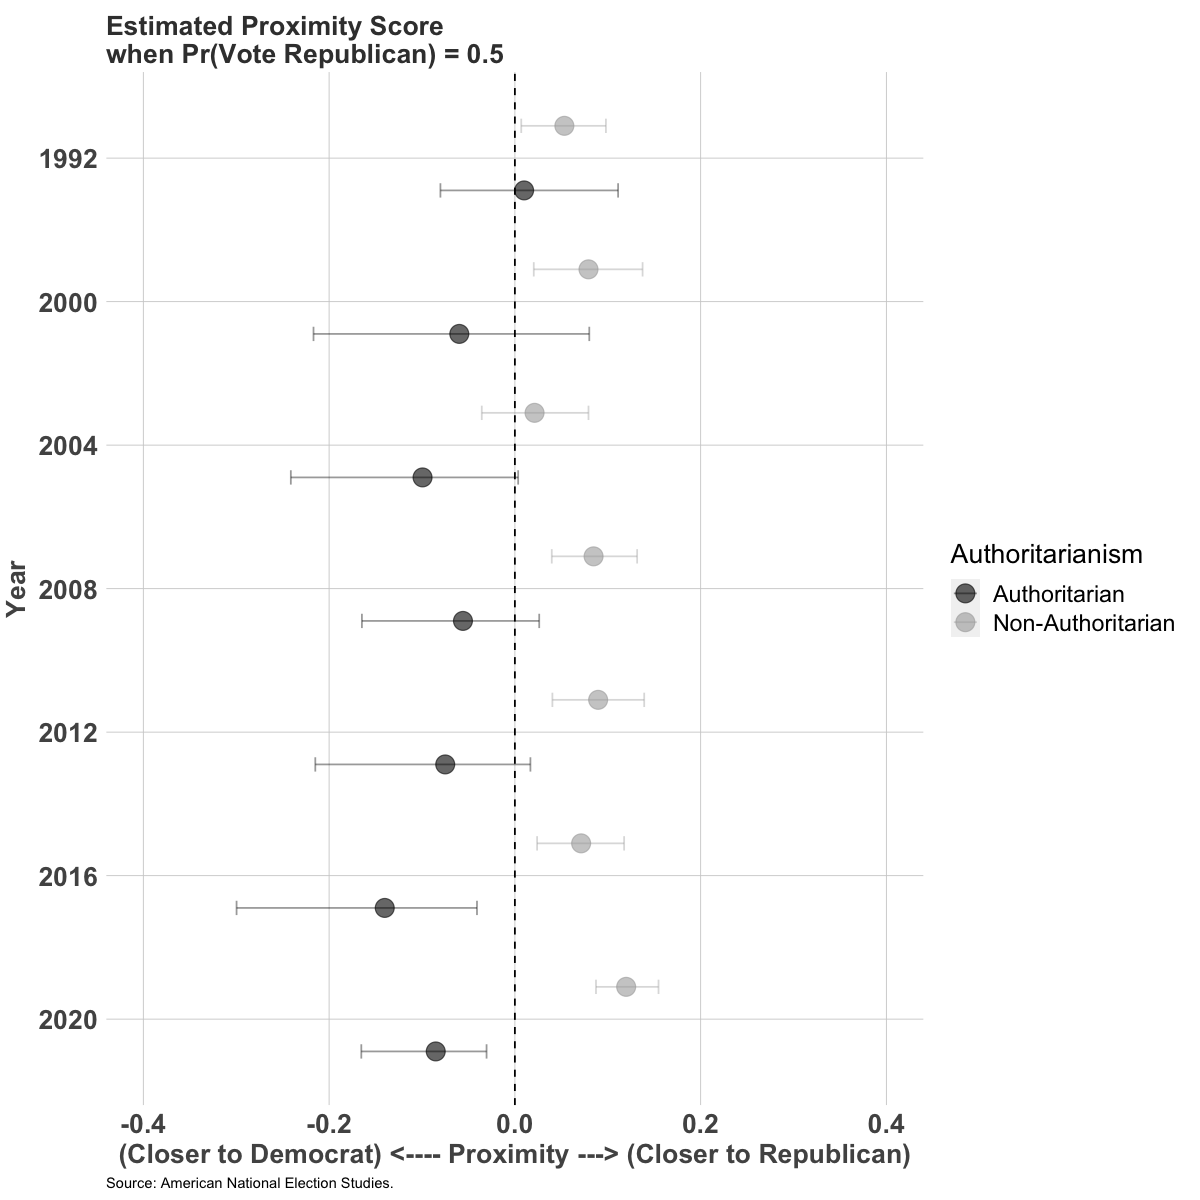

In [135]:
rbind(
  predict_term(group = "Authoritarian") %>% mutate(group = "Authoritarian"),
  predict_term(group = "Non") %>% mutate(group = "Non-Authoritarian")
 ) %>%
 ggplot(aes(x = as.factor(year), y = mean, ymin = low, ymax = high, color = as.factor(group), group = as.factor(group))) +
   geom_point(size = 5, alpha = 0.60, position = position_dodge(width = 0.9)) +
   geom_errorbar(width = 0.20, alpha = 0.4, position = position_dodge(width = 0.9)) +
   ggtitle("Estimated Proximity Score\nwhen Pr(Vote Republican) = 0.5") +
   # Add a subtitle
   scale_y_continuous("(Closer to Democrat) <---- Proximity ---> (Closer to Republican)", limits = c(-0.4, 0.4)) +
   ggtheme +
   # Change the y axis limits from 0 to 0.8
   # scale_y_continuous("Deviation from Spatial Voting", limits = c(-0.4, 0.4))
   labs(x = "Year") +
   # Add a caption
   labs(caption = "Source: American National Election Studies.") +
   # alignt he caption to the left
   theme(plot.caption = element_text(hjust = 0)) +
   # Make the title smaller, and the second line should be smaller than the first
   theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
   # reverse the x axis
   coord_flip() +
   geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
   # revser the order of year
   # Change the color of label
   scale_color_manual("Authoritarianism", values = c("black", "darkgrey")) +
   scale_x_discrete(limits = rev(levels(as.factor(pred$year))))



In [144]:
ch9models[["spatialDat"]] %>%
  select(diffOfdiff, year) %>%
    group_by(year, party_identification) %>%
  group_by(decile) %>%
  summarise(
    min_diffOfdiff = min(diffOfdiff),
    max_diffOfdiff = max(diffOfdiff)
  )



[1] "vote"              "differenceD"       "differenceR"      
 [4] "authoritarianism"  "authoritarianism2" "college"          
 [7] "year"              "diffCR"            "diffCD"           
[10] "diffOfdiff"